In [1]:
import pandas as pd
import country_converter as coco
cc = coco.CountryConverter()

In [21]:
df=pd.read_csv('un_general_debates_extended.csv', index_col=0)
df

,country,text,year,country_name_short
0,CHL,I shall occupy this rostrum for a few minutes ...,1946,Chile
1,COL,The Colombian delegation does not consider it ...,1946,Colombia
2,BLR,As more than a year has elapsed since the Unit...,1946,Belarus
3,IND,I stand before this great Assembly — unique in...,1946,India
4,GBR,"In his great pronouncement here the other day,...",1946,United Kingdom
...,...,...,...,...
10563,GAB,"It is my pleasant duty to offer you, Mr. Presi...",1963,Gabon
10564,TCD,"It Is not without a certain pride, mixed with ...",1963,Chad
10565,COL,"Colombia, and the delegation which represents ...",1963,Colombia
10566,TUN,"Mr. President, it is a pleasure for me first o...",1963,Tunisia


In [22]:
df_huntington=pd.read_csv('Huntingtons.csv',encoding='cp1252')
dict_iso_to_huntigton = df_huntington.set_index('alpha-2')['Huntingtons_class'].to_dict()
# vatican is missing and namibia mistaken for a nan
dict_iso_to_huntigton['VA']='Western'
dict_iso_to_huntigton['NA']='African'

In [23]:
import country_converter as coco
cc = coco.CountryConverter()

country_name_short=df['country_name_short']
iso_region_names = cc.convert(names = country_name_short, to = 'ISO2')
# huntington_names = [dict_iso_to_huntigton[iso] for iso in iso_region_names]
# df.loc[:,'Huntigton_region']=huntington_names

In [24]:
import country_converter as coco
cc = coco.CountryConverter()

country_name_short=df['country_name_short']
un_region_names = cc.convert(names = country_name_short, to = 'UNregion')

df.loc[:,'UN_region']=un_region_names

In [25]:
# convert text data to lower case (for easier analysis)
data=df
data['text'] = data['text'].str.lower()
data['char_count'] = data['text'].str.len()
data['words'] = data['text'].str.split(' ')
data['sentences'] = data['text'].str.split('.')
data['word_count'] = data['words'].str.len()
data['sentence_count'] = data['sentences'].str.len()
data['word_length'] = data['char_count'] / data['word_count']
data['sentence_length'] = data['word_count'] / data['sentence_count']

print('avg char count:', data['char_count'].mean())
print()
print('avg word count:', data['word_count'].mean())
print('avg word length:', data['word_length'].mean())
print()
print('avg sentence count:', data['sentence_count'].mean())
print('avg sentence len:', data['sentence_length'].mean())

avg char count: 18353.741663508907

avg word count: 2844.5408298597954
avg word length: 6.52357951278917

avg sentence count: 124.89010989010988
avg sentence len: 23.446213725388034


## LDA

In [93]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import ast
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jahandelestangjim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
data_topics=pd.read_csv('un_general_debates_extended_cleaned_topics.csv', index_col=0)
data_topics = data_topics.dropna()
data_topics['topics_name'] = data_topics['topics_name'].astype(str)
data_topics['clean_text'] = data_topics['clean_text'].apply(ast.literal_eval)
data_topics['topics_name'] = data_topics['topics_name'].str.replace(' ', '_')
data_topics['text'] = data_topics['text'].astype(str)

In [43]:
data['text']=data['text'].astype(str)
def clean(s):    
    # Remove any tags:
    cleaned = re.sub(r"(?s)<.?>", " ", s)
    # Keep only regular chars:
    cleaned = re.sub(r"[^A-Za-z0-9(),*!?\'\`]", " ", cleaned)
    # Remove unicode chars
    cleaned = re.sub("\\\\u(.){4}", " ", cleaned)
    # Remove things between brackets
    cleaned = re.sub("\[.*?\]", " ", cleaned)

    return cleaned.strip()

# clean text
data.loc[:,'text'] = data.text.apply(lambda x: clean(x))
merged_df =data.merge(data_topics, on='text', how='inner')

data['topics']=merged_df['topics_name']

In [86]:
country_names = [name for name in data['country_name_short'].unique()]
summary_df=pd.DataFrame(index=country_names)
# summary_df['average_speech_length (num sentences)']=data['sentence_count'].groupby(data['country_name_short']).mean()
# summary_df['min_speech_length (num sentences)']=data['sentence_count'].groupby(data['country_name_short']).min()
# summary_df['max_speech_length (num sentences)']=data['sentence_count'].groupby(data['country_name_short']).max()
summary_df['num_speeches']=data['country_name_short'].groupby(data['country_name_short']).count()
summary_df['speech_proportion_economy'] = data[data['topics'] == 'Economy'].groupby('country_name_short')['country_name_short'].count() / summary_df['num_speeches']
summary_df['speech_proportion_international'] = data[data['topics'] == 'International_Relations_and_Geopolitics'].groupby('country_name_short')['country_name_short'].count() / summary_df['num_speeches']
summary_df['speech_proportion_climate'] = data[data['topics'] == 'Climate_Change'].groupby('country_name_short')['country_name_short'].count() / summary_df['num_speeches']
summary_df['speech_proportion_culture'] = data[data['topics'] == 'Culture'].groupby('country_name_short')['country_name_short'].count() / summary_df['num_speeches']
summary_df['speech_proportion_justice'] = data[data['topics'] == 'Human_Rights_and_Social_Justice'].groupby('country_name_short')['country_name_short'].count() / summary_df['num_speeches']
# summary_df['first_year_speech'] = data['year'].groupby(data['country_name_short']).min()
summary_df=summary_df[['speech_proportion_economy', 'speech_proportion_international', 'speech_proportion_climate', 'speech_proportion_culture', 'speech_proportion_justice']]

In [89]:
summary_df.fillna(0)

,speech_proportion_economy,speech_proportion_international,speech_proportion_climate,speech_proportion_culture,speech_proportion_justice
Chile,0.026316,0.776316,0.052632,0.039474,0.105263
Colombia,0.054054,0.756757,0.054054,0.013514,0.108108
Belarus,0.038961,0.805195,0.038961,0.025974,0.090909
India,0.092105,0.736842,0.039474,0.039474,0.092105
United Kingdom,0.090909,0.727273,0.064935,0.012987,0.103896
...,...,...,...,...,...
South Africa,0.018519,0.796296,0.111111,0.018519,0.055556
Tonga,0.045455,0.772727,0.090909,0.000000,0.090909
Marshall Islands,0.032258,0.774194,0.096774,0.000000,0.096774
Slovakia,0.166667,0.633333,0.033333,0.066667,0.100000


In [88]:
summary_df.to_csv('speech_topic_proportion_per_country.csv')

In [60]:
data['sentence_count'].groupby(data['country_name_short']).min()

country_name_short
Afghanistan    28
Albania        39
Algeria        35
Andorra        46
Angola         26
               ..
Venezuela      39
Vietnam        36
Yemen          28
Zambia         34
Zimbabwe       45
Name: sentence_count, Length: 195, dtype: int64

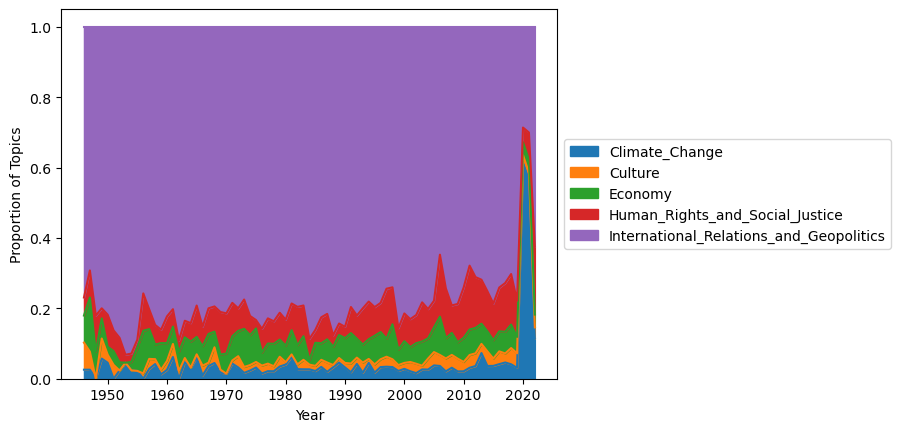

In [ ]:
import pandas as pd
df=data_topics
# Assuming df is your DataFrame with columns 'topics' and 'years'
grouped = df.groupby(['year', 'topics_name']).size().unstack(fill_value=0)
import matplotlib.pyplot as plt
total_count = grouped.sum(axis=1)
normalized_grouped = grouped.divide(total_count, axis=0)

ax = normalized_grouped.plot(kind='area', stacked=True)

plt.xlabel('Year')
plt.ylabel('Proportion of Topics')

legend = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) 

plt.show()


In [ ]:
# Remove unusual symbols from description
def clean(s):    
    # Remove any tags:
    cleaned = re.sub(r"(?s)<.?>", " ", s)
    # Keep only regular chars:
    cleaned = re.sub(r"[^A-Za-z0-9(),*!?\'\`]", " ", cleaned)
    # Remove unicode chars
    cleaned = re.sub("\\\\u(.){4}", " ", cleaned)
    # Remove things between brackets
    cleaned = re.sub("\[.*?\]", " ", cleaned)
    return cleaned.strip()

data.loc[:,'sentences'] = data.text.apply(lambda x: clean(x))

def preprocess_data(documents):
    stop_words = stopwords.words('english')
    # Tokenize and remove stopwords
    
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in documents]
    
    return texts

In [ ]:
processed_texts = preprocess_data(data['sentences'])


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(processed_texts)
# Create Corpus
texts = processed_texts
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# Set number of topics
num_topics = 20

In [ ]:
# Build LDA model
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42, passes=10, alpha='auto', per_word_topics=True)

In [ ]:
# Print the keywords for each topic
pprint(lda_model.print_topics())

[(0,
  '0.014*"global" + 0.011*"climate" + 0.010*"development" + 0.009*"change" + '
  '0.008*"world" + 0.008*"nations" + 0.008*"sustainable" + 0.007*"must" + '
  '0.007*"united" + 0.007*"challenges"'),
 (1,
  '0.019*"nations" + 0.019*"united" + 0.018*"international" + 0.012*"security" '
  '+ 0.010*"development" + 0.010*"cooperation" + 0.007*"efforts" + '
  '0.007*"peace" + 0.007*"states" + 0.006*"general"'),
 (2,
  '0.014*"countries" + 0.012*"international" + 0.010*"world" + 0.008*"must" + '
  '0.007*"peace" + 0.006*"us" + 0.006*"community" + 0.005*"people" + '
  '0.005*"situation" + 0.005*"country"'),
 (3,
  '0.015*"countries" + 0.014*"world" + 0.009*"economic" + 0.007*"nations" + '
  '0.007*"development" + 0.007*"peoples" + 0.006*"must" + 0.006*"country" + '
  '0.006*"human" + 0.005*"social"'),
 (4,
  '0.019*"world" + 0.013*"us" + 0.013*"people" + 0.010*"war" + 0.009*"one" + '
  '0.008*"today" + 0.006*"must" + 0.005*"new" + 0.005*"country" + 0.005*"let"'),
 (5,
  '0.015*"peace" + 0.0

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score:', coherence_lda)

Coherence Score: 0.34716087326461204


Chat GPT offers this summary :

* Climate - With key terms like "global," "climate," "change," and "sustainable."
* Cooperation - Prominent terms include "nations," "united," "international," and "cooperation."
* Community - Emphasizing "countries," "international," and "world."
* Development - With significant words such as "countries," "development," and "economic."
* World Affairs - Including keywords like "world," "us," "people," and "war."
* Small States - Notable words are "states," "small," "island," and "pacific."
* Africa - Strong focus on terms like "africa," "african," and "south."
* People - Main words like "people," "united," "states," and "republic."
* Middle East - Contains terms such as "israel," "arab," and "palestine."
* Security - Notable terms include "security," "peace," and "iraq."
* Politics - Features words such as "political," "international," and "nations."
* Governance - Keywords include "government," "country," and "democracy."
* South-South Cooperation - Emphasizing terms like "south," "nations," and "developing."
* Human Rights - Focused on keywords like "rights," "human," and "people."
* Nuclear Issues - Contains terms like "nuclear," "security," and "peace."
* Latin America - Keywords include "central," "american," and "government."
* Disarmament - Contains terms like "disarmament," "soviet," and "nuclear."
* Economic Development - Features words such as "development," "international," and "economic."
* International Relations - Emphasizing terms like "united," "states," and "countries."

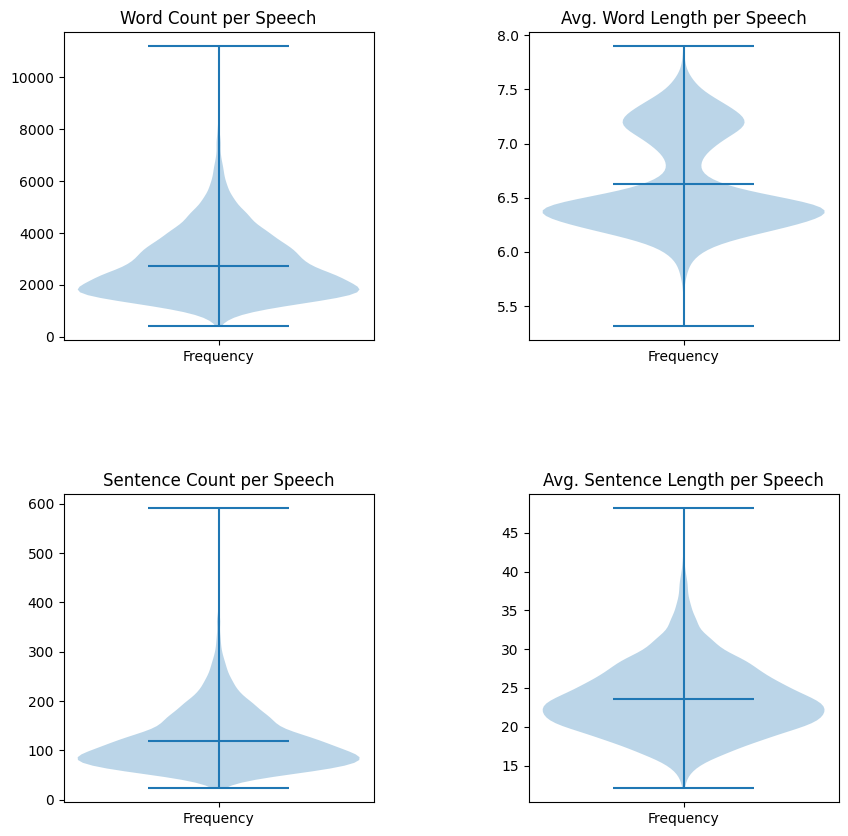

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
all_data = [data]

axes[0, 0].violinplot(data['word_count'], showmeans=True, showmedians=False)
axes[0, 0].set_title('Word Count per Speech')

axes[0, 1].violinplot(data['word_length'], showmeans=True, showmedians=False)
axes[0, 1].set_title('Avg. Word Length per Speech')

axes[1, 0].violinplot(data['sentence_count'], showmeans=True, showmedians=False)
axes[1, 0].set_title('Sentence Count per Speech')

axes[1, 1].violinplot(data['sentence_length'], showmeans=True, showmedians=False)
axes[1, 1].set_title('Avg. Sentence Length per Speech')

# add x-tick labels
plt.setp(axes, xticks=[y+1 for y in range(len(all_data))], xticklabels=['Frequency'])
fig.subplots_adjust(wspace=.5, hspace=.5)
plt.show()

In [ ]:
# show top and bottom 5 countries by avg sentence count, avg word count, and avg sentence length
a = data['sentence_count'].groupby(data['country']).mean()
print('Avg. Sentence Count')
print(pd.concat([a.sort_values(ascending=False)[:3], a.sort_values(ascending=False)[-3:]], axis=0))
print()

a = data['word_count'].groupby(data['country']).mean()
print('Avg. Word Count')
print(pd.concat([a.sort_values(ascending=False)[:3], a.sort_values(ascending=False)[-3:]], axis=0))
print()

a = data['sentence_length'].groupby(data['country']).mean()
print('Avg. Sentence Length')
print(pd.concat([a.sort_values(ascending=False)[:3], a.sort_values(ascending=False)[-3:]], axis=0))
print()

Avg. Sentence Count
country
DEU    210.790698
RUS    210.733333
USA    202.695652
SMR     59.291667
MNE     56.100000
TON     54.933333
Name: sentence_count, dtype: float64

Avg. Word Count
country
RUS    4240.577778
IRL    4109.244444
CUB    3953.586957
LTU    1420.560000
UZB    1375.100000
BRN    1086.322581
Name: word_count, dtype: float64

Avg. Sentence Length
country
VAT    29.992076
BHR    29.592585
TUN    28.918874
DEU    17.219644
FIN    17.071593
SWE    16.691306
Name: sentence_length, dtype: float64



In [ ]:
counts_per_year = df['year'].value_counts()
print(counts_per_year)

year
2012    195
2011    194
2014    194
2013    193
2006    193
2015    193
2009    193
2008    192
2004    192
2007    191
2001    189
2010    189
2003    189
2002    188
2005    185
1996    181
1999    181
1998    181
1994    178
2000    178
1997    176
1993    175
1995    172
1992    167
1991    162
1990    156
1988    154
1989    153
1987    152
1984    150
1983    149
1986    149
1980    149
1982    147
1981    145
1979    144
1978    141
1977    140
1985    137
1976    134
1974    129
1975    126
1972    125
1973    120
1971    116
1970     70
Name: count, dtype: int64


In [94]:
import operator
import matplotlib.pyplot as plt

import numpy as np 

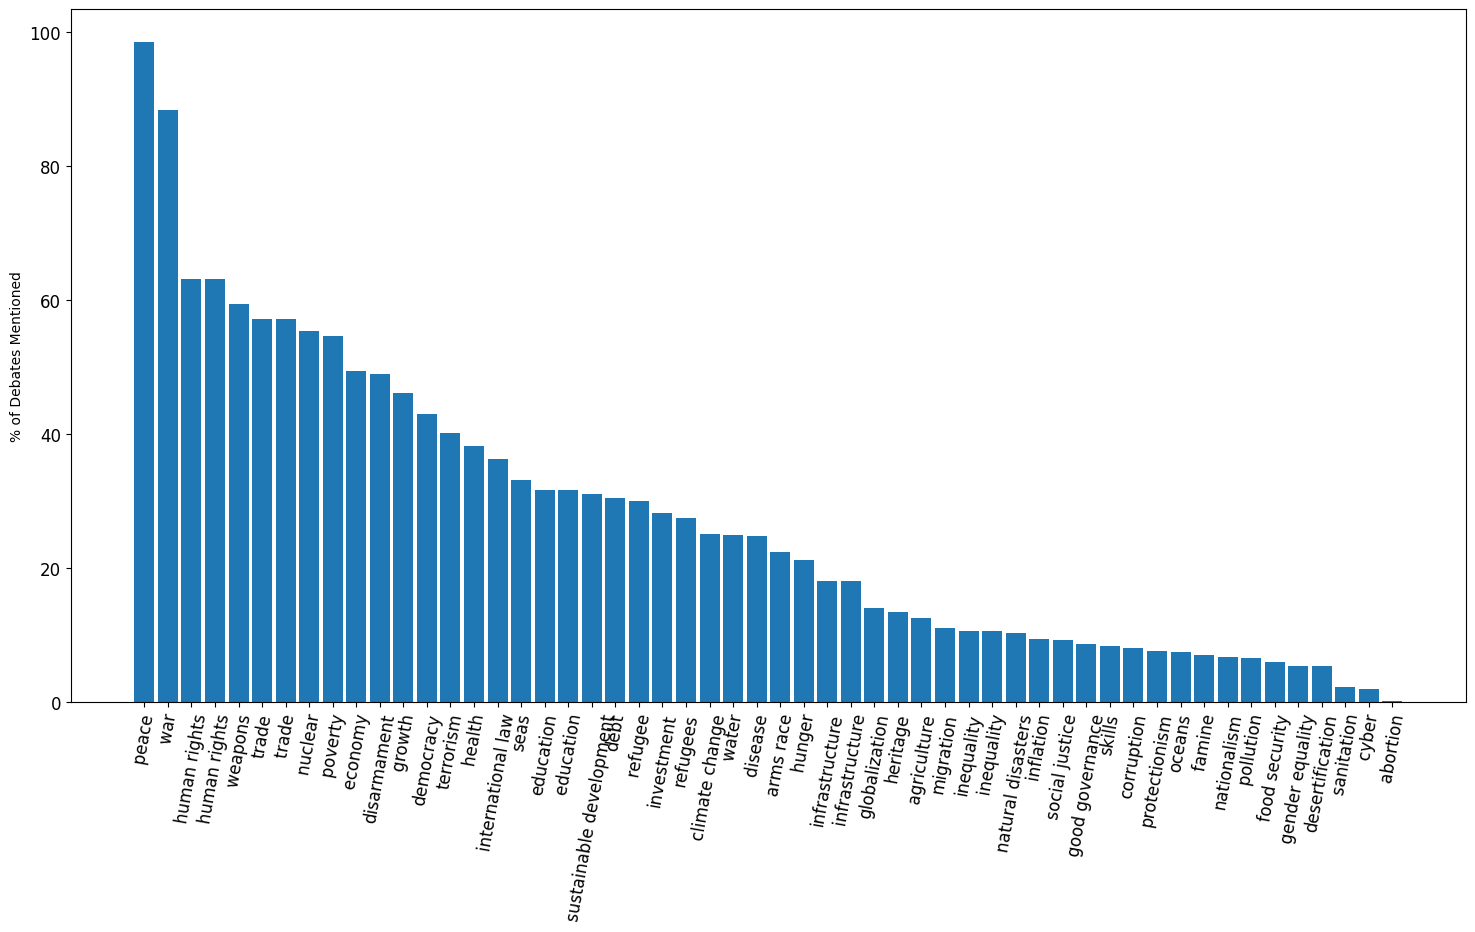

In [109]:
# create list of topics that UN member nations might discuss
topics = [' nuclear', ' weapons', ' nuclear weapons', ' chemical weapons', 
          ' biological weapons', ' mass destruction', ' peace', ' war',
          ' nuclear war', ' civil war', ' terror', ' genocide', ' holocaust',
          ' water', ' famine', ' disease', ' hiv', ' aids', ' malaria', ' cancer',
          ' poverty', ' human rights', ' abortion', ' refugee', ' immigration',
          ' equality', ' democracy', ' freedom', ' sovereignty', ' dictator',
          ' totalitarian', ' vote', ' energy', ' oil',  ' coal',  ' income',
          ' economy', ' growth', ' inflation', ' interest rate', ' security',
          ' cyber', ' trade', ' inequality', ' pollution', ' global warming',
          ' hunger', ' education', ' health', ' sanitation', ' infrastructure',
          ' virus', ' regulation', ' food', ' nutrition', ' transportation',
          ' violence', ' agriculture', ' diplomatic', ' drugs', ' obesity',
          ' islam', ' housing', ' sustainable', 'nuclear energy']

topics=['arms race', 'disarmament', ' nuclear', ' weapons', ' peace', ' war',' water', ' famine', ' disease',
        'international law', 'climate change', 'desertification', 'natural disasters', ' poverty', ' human rights', ' abortion', ' refugee',
        'inequality', 'social justice', 'gender equality', 'migration', 'refugees', 'trade', 'investment', 'globalization', 
        'protectionism', 'debt', 'sustainable development', 'food security', 'agriculture', 'infrastructure', 'education', 
        ' economy', ' growth', ' inflation', 
' cyber', ' trade', ' inequality', ' pollution',' hunger', ' education', ' health', ' sanitation', ' infrastructure',
        'skills', 'heritage', 'terrorism', 'oceans', 'seas', 'nationalism', 'democracy', 'human rights', 'corruption', 'good governance']
dictionary = {}

for i in topics:    
    dictionary[i] = data['year'][data['text'].str.contains(i)].count() / len(data) * 100

sorted_dictionary = sorted(dictionary.items(), key=operator.itemgetter(1), reverse=True)

labels = [i[0] for i in sorted_dictionary]
values = [i[1] for i in sorted_dictionary]
xs = np.arange(len(labels))

width = .85
plt.figure(figsize=(18, 9))
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xticks(rotation=80)
plt.ylabel('% of Debates Mentioned')

plt.bar(xs, values, width, align='center')
plt.xticks(xs, labels)
plt.show()

In [108]:
liste=[value for value in dictionary if dictionary[value]>=7]
print(liste)
topics=[topic for topic in topics if topic not in liste]

['arms race', 'disarmament', ' nuclear', ' weapons', ' peace', ' war', ' water', ' famine', ' disease', 'international law', 'climate change', 'natural disasters', ' poverty', ' human rights', ' refugee', 'inequality', 'social justice', 'migration', 'refugees', 'trade', 'investment', 'globalization', 'protectionism', 'debt', 'sustainable development', 'agriculture', 'infrastructure', 'education', ' economy', ' growth', ' inflation', ' trade', ' inequality', ' hunger', ' education', ' health', ' infrastructure', 'skills', 'heritage', 'terrorism', 'oceans', 'seas', 'democracy', 'human rights', 'corruption', 'good governance']


In [ ]:
# count number of debates in which a nation participates
countries = data['year'].groupby(data['country']).count()
countries = pd.DataFrame(countries.reset_index(drop=False))
countries.columns = ['country', 'num speeches']

print('Most Vocal Member Nations')
print('max number of speeches given:', countries['num speeches'].max())
print(countries[countries['num speeches'] == countries['num speeches'].max()].country.unique())
print()

countries = countries.sort_values(by='num speeches')
print('Least Vocal Member Nations')
print('min number of speeches given:', countries['num speeches'].min())
print(countries.country[:10].unique().tolist())

Most Vocal Member Nations
max number of speeches given: 46
['ALB' 'ARG' 'AUS' 'AUT' 'BEL' 'BLR' 'BOL' 'BRA' 'CAN' 'COG' 'COL' 'CUB'
 'DZA' 'ECU' 'FRA' 'GBR' 'GHA' 'GTM' 'IDN' 'IND' 'IRN' 'IRQ' 'ISL' 'ISR'
 'ITA' 'JPN' 'LKA' 'MAR' 'MEX' 'NLD' 'NZL' 'PAK' 'PER' 'PHL' 'RWA' 'SDN'
 'SLV' 'SYR' 'TUN' 'TUR' 'UKR' 'URY' 'USA' 'VEN']

Least Vocal Member Nations
min number of speeches given: 5
['SSD', 'EU', 'MNE', 'VAT', 'TLS', 'KIR', 'CHE', 'TON', 'TUV', 'NRU']


In [ ]:
# Plot a horizontal bar graph displaying the frequency of a given topic by country
def freqMentioned (df, country_list, topic_list, colors):
    data = df.loc[df['country'].isin(country_list)]

    for i in topic_list:
        data[i] = data['text'].str.contains(i)
        data[i].loc[data[i] == False] = np.nan

    country = country_list[0]
    data_out = pd.DataFrame(data.loc[data['country'] == country].count())
    data_out = (data_out.T)[topic_list]
    
    # sort the columns by summed occurence in countries specified
    countries = country_list.copy()
    countries.remove(country)

    for i in countries:
        a = pd.DataFrame(data.loc[data['country'] == i].count())
        a = (a.T)[topic_list].copy()
        data_out = pd.concat([data_out, a], axis=0)

        dictionary = {}
    
    for i in topic_list:
        dictionary[i] = data_out[i].sum()
        
    sorted_dictionary = sorted(dictionary.items(), key=operator.itemgetter(1), reverse=True)
    data_out = data_out[[i[0] for i in sorted_dictionary]]
    data_out.index = country_list
    data_out.T.plot(kind="barh", width=.6, stacked=True, figsize = (10, len(topic_list)/3), color=colors).legend(bbox_to_anchor=(1, 1))
    
    return data_out

/tmp/ipykernel_16889/3111517202.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[i] = data['text'].str.contains(i)
/tmp/ipykernel_16889/3111517202.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment 

,peace,security,war,nuclear,weapons,human rights,terror,trade,freedom,economy,...,malaria,pollution,housing,global warming,virus,nutrition,immigration,sanitation,cancer,transportation
USA,46,45,44,40,44,41,37,33,40,32,...,5,6,1,1,1,1,1,1,1,1
RUS,45,45,42,40,41,32,33,15,30,14,...,2,0,3,0,2,1,0,0,0,0
GBR,45,46,44,30,30,30,27,34,29,24,...,2,1,3,4,0,1,0,1,0,0
FRA,46,46,43,32,34,36,29,26,29,15,...,3,2,1,3,1,0,0,1,1,0
CHN,45,45,41,36,28,12,17,33,13,35,...,0,1,0,0,0,0,2,0,1,1


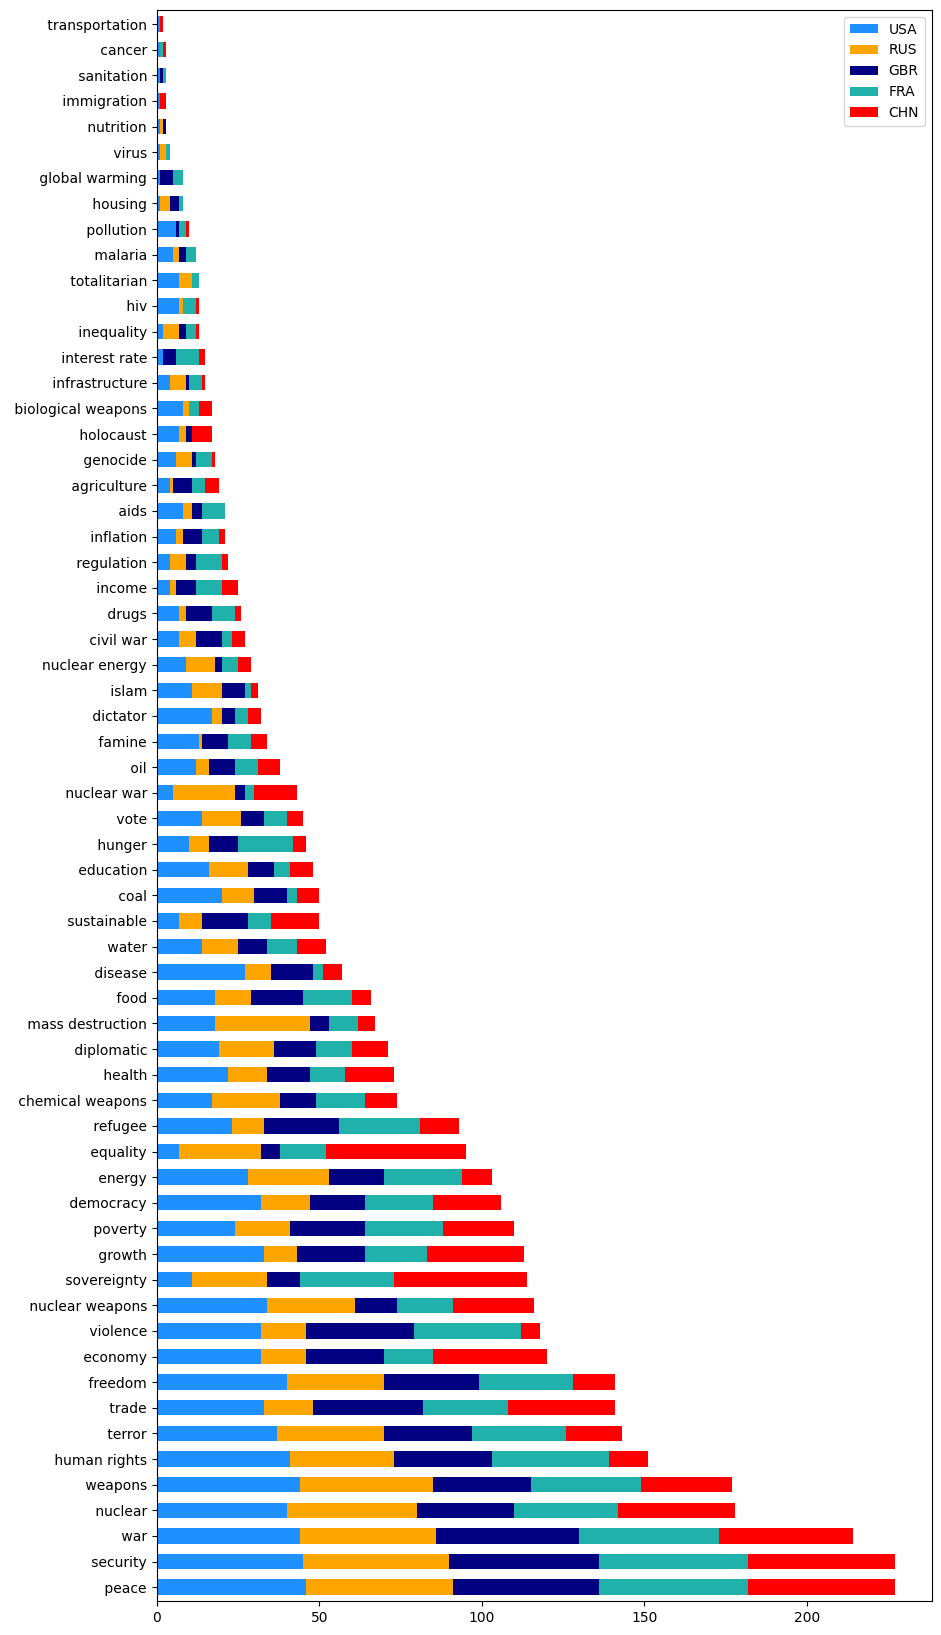

In [ ]:
# Permanent Members of the UN Security Council
sec_council = ['USA', 'RUS', 'GBR', 'FRA', 'CHN']

topics = []
for i in sorted_dictionary:
    if i[1] > 1:
        topics.append(i[0])

colors = ['dodgerblue', 'orange', 'navy', 'lightseagreen', 'r']
freqMentioned(data, sec_council, topics, colors)

/tmp/ipykernel_16889/3111517202.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[i] = data['text'].str.contains(i)
/tmp/ipykernel_16889/3111517202.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment 

,peace,conflict,united states,asia,human right,treaty,terror,partner,growth,democracy,...,tokyo,seoul,starvation,nuclear material,ally,grain,south china sea,navy,rice,dmz
USA,46,42,46,30,41,31,37,27,33,32,...,7,2,4,10,1,3,2,1,2,0
RUS,45,43,38,30,32,40,33,37,10,15,...,1,1,2,1,1,1,0,1,0,0
KOR,25,24,11,22,23,17,18,15,14,18,...,1,15,3,3,0,0,0,0,0,1
PRK,25,11,25,22,20,8,9,2,1,8,...,0,1,0,0,0,0,0,0,0,0
JPN,46,41,34,37,29,32,23,23,24,14,...,31,6,8,0,0,0,0,0,1,0
CHN,45,38,24,37,12,22,17,11,30,21,...,0,0,2,0,8,4,1,1,0,0


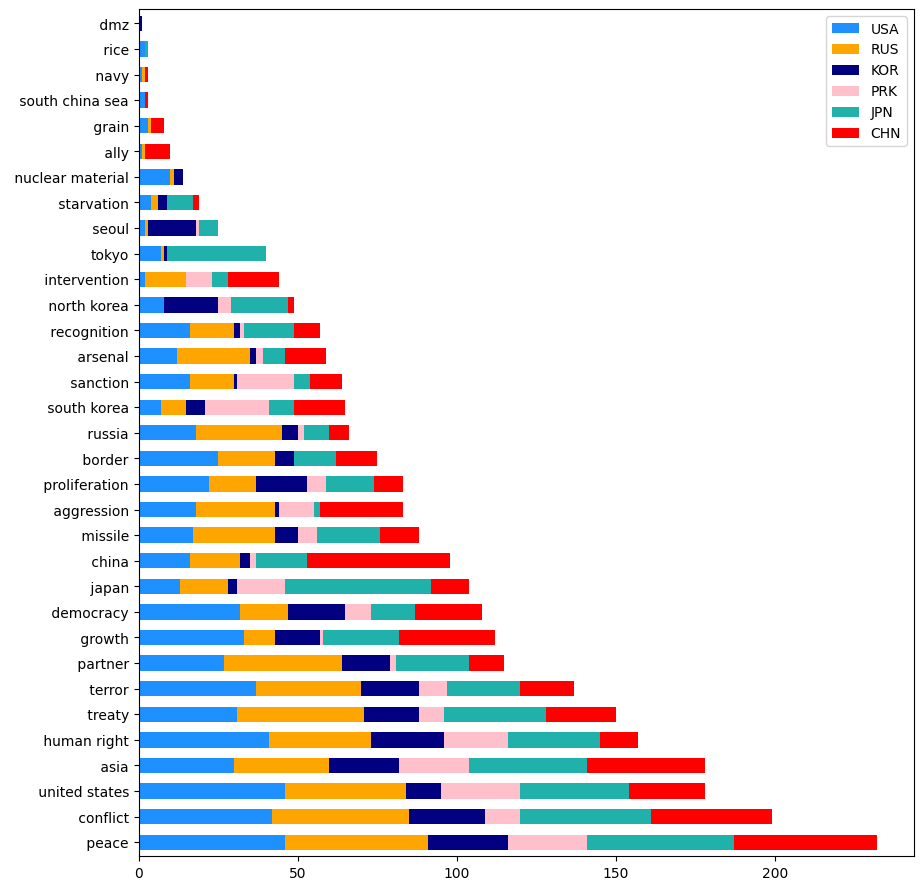

In [ ]:
# Korea & Neighbors
countries = ['USA', 'RUS', 'KOR', 'PRK', 'JPN', 'CHN']

topics = [' united states', ' north korea', ' south korea', ' south china sea', ' asia', ' peace',
          ' navy', ' arsenal', ' aggression', ' treaty', ' dmz', ' missile',
          ' nuclear material', ' sanction', ' terror', ' border', ' seoul',
          ' growth', ' democracy', 'tokyo', ' intervention', ' human right',
          ' recognition', ' ally', ' partner', ' japan', ' china', ' proliferation',
          ' conflict', ' russia', ' rice', ' grain', ' starvation']

colors = ['dodgerblue', 'orange', 'navy', 'pink', 'lightseagreen', 'r']
freqMentioned(data, countries, topics, colors)

/tmp/ipykernel_16889/3111517202.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[i] = data['text'].str.contains(i)
/tmp/ipykernel_16889/3111517202.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment 

,peace,arab,israel,conflict,terror,palestine,iraq,lebanon,syria,jerusalem,...,judaism,sunni,shia,solar,mecca,opec,foreign investment,desalination,gender equality,free speech
USA,46,25,29,42,37,8,26,14,12,5,...,0,3,4,2,0,1,0,0,0,1
ISR,46,44,46,40,43,18,22,37,38,28,...,3,1,0,3,0,0,0,2,0,0
IRQ,44,41,26,36,29,28,46,19,10,13,...,0,1,1,0,0,1,1,0,1,0
EGY,43,43,41,40,26,33,29,23,30,27,...,2,0,0,0,2,0,0,0,0,0
PSE,18,17,18,17,13,18,7,3,7,16,...,1,0,0,0,0,0,0,0,0,0
JOR,45,44,44,39,23,38,29,26,24,34,...,1,0,0,0,0,0,0,0,0,0
LBN,42,40,42,37,26,29,11,42,25,10,...,0,0,0,0,1,0,0,0,0,0
SYR,46,46,46,38,28,24,24,30,45,25,...,0,0,0,0,1,0,1,0,0,0


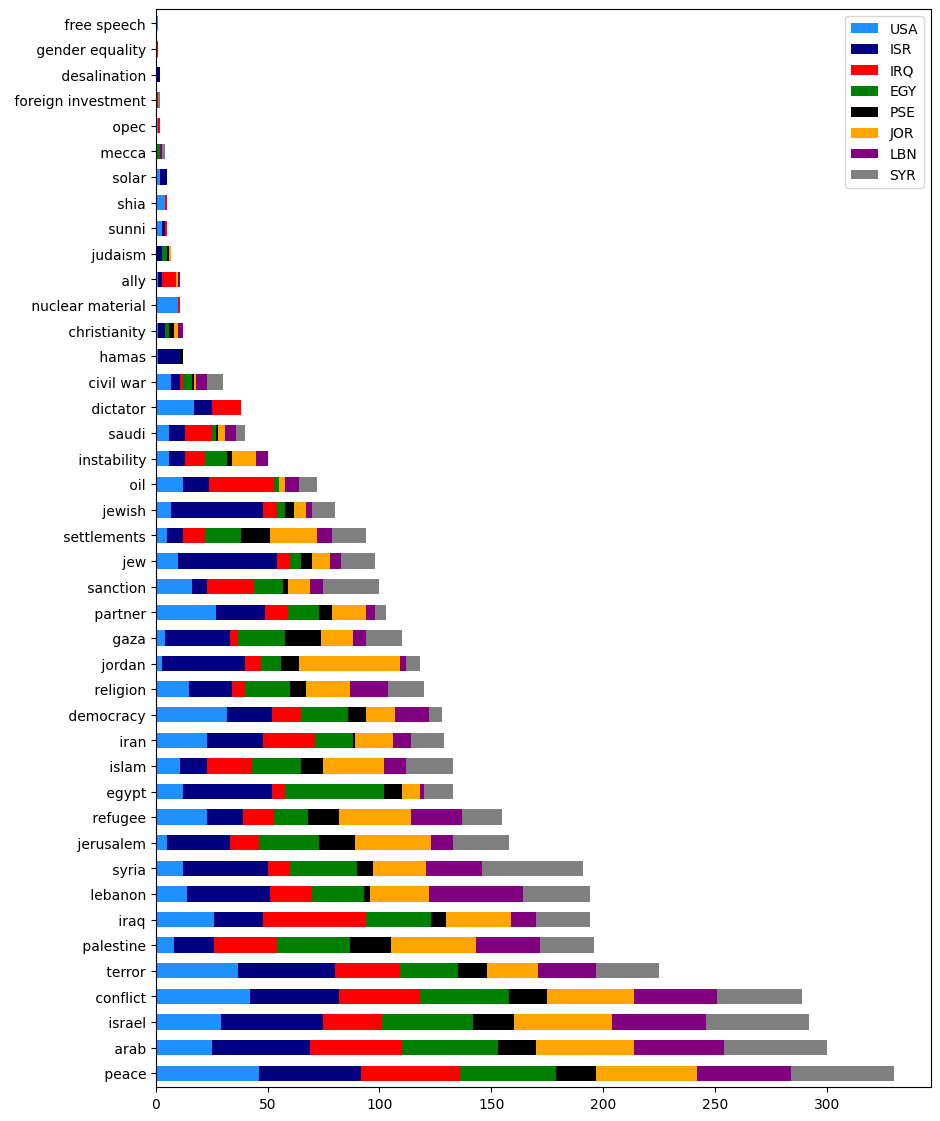

In [ ]:
# Middle East
countries = ['USA', 'ISR', 'IRQ', 'EGY', 'PSE', 'JOR', 'LBN', 'SYR']

topics = [' iran', ' iraq', ' israel', ' egypt', ' palestine', ' terror', ' jordan',
          ' refugee', ' hamas', ' lebanon', ' saudi', ' oil', ' nuclear material',
          ' sanction', ' settlements', ' gaza', ' opec', ' foreign investment',
          ' desalination', ' syria', ' dictator', ' democracy', ' gender equality',
          ' islam', ' jewish', ' judaism', ' jerusalem', ' religion', ' christianity',
          ' mecca', ' sunni', ' shia', ' solar', ' instability', ' civil war', ' peace',
          ' partner', ' ally', ' arab', ' conflict', ' jew', ' free speech']

colors = ['dodgerblue', 'navy', 'r', 'green', 'black', 'orange', 'purple', 'grey']
freqMentioned(data, countries, topics, colors)

/tmp/ipykernel_16889/3111517202.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[i] = data['text'].str.contains(i)
/tmp/ipykernel_16889/3111517202.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment 

,fruit,water,climate change,coal,oil,tariff,iron,gas,wood,paper,...,leather,tin,copper,rubber,glass,aluminum,siicon,lithium,magnesium,nickel
USA,7,14,8,20,12,9,9,9,0,4,...,0,0,0,0,1,0,0,0,0,0
RUS,17,11,6,11,4,3,3,1,2,5,...,1,1,0,0,0,0,0,0,0,0
CAN,4,12,8,8,6,6,4,3,2,4,...,0,0,0,0,0,0,0,0,0,0
NGA,3,10,7,0,11,2,4,0,6,0,...,0,0,0,1,0,0,0,0,0,0
IND,9,10,12,6,6,4,6,2,6,4,...,1,0,1,0,0,0,0,0,0,0
BRA,23,2,10,3,8,11,3,7,6,0,...,0,0,0,0,0,0,0,0,0,0
CHN,10,9,8,7,7,3,3,0,0,5,...,0,0,0,0,0,0,0,0,0,0


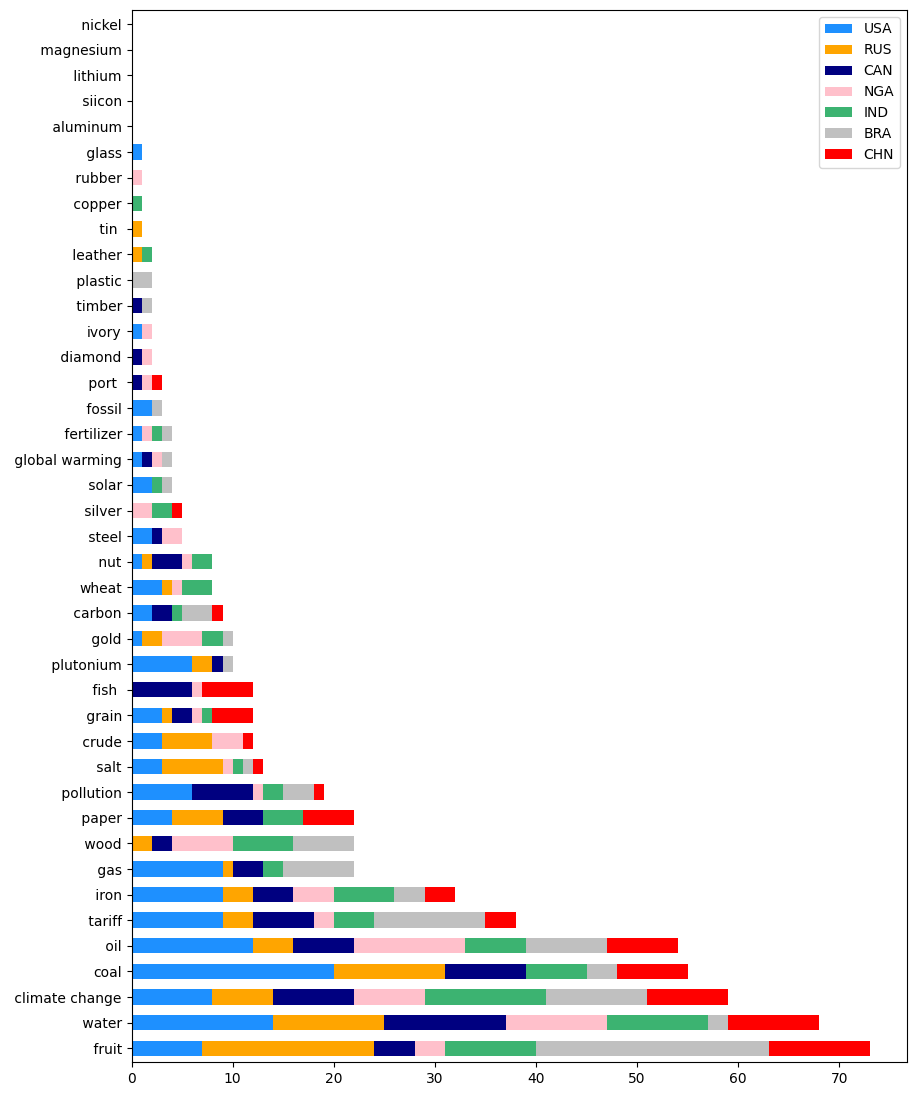

In [ ]:
# BRINC + USA + Canada
countries = ['USA', 'RUS', 'CAN', 'NGA', 'IND', 'BRA', 'CHN']

topics = [' oil', ' water', ' crude', 'coal', ' gas', ' solar', 'wheat',
          ' tin ', ' diamond', ' wood', 'ivory', ' plutonium', ' fossil',
          ' pollution', ' carbon', ' global warming', ' climate change', 
          ' fertilizer', ' aluminum', ' steel', ' iron', ' timber', ' siicon',
          ' gold', ' silver', ' copper', ' lithium', ' salt', ' magnesium',
          ' rubber', ' paper', ' plastic', ' glass', ' nickel', ' grain',
          ' fruit', ' tariff', ' fish ', ' port ', ' leather', ' nut']

colors = ['dodgerblue', 'orange', 'navy', 'pink', 'mediumseagreen', 'silver', 'r']
freqMentioned(data, countries, topics, colors)

## Try to extract data from PDF

In [ ]:
import PyPDF2

def extract_text_from_pdf(pdf_path):
    text = ""
    with open(pdf_path, "rb") as file:
        reader = PyPDF2.PdfReader(file)
        num_pages = len(reader.pages)
        for page_num in range(num_pages):
            page = reader.pages[page_num]
            text += page.extract_text ()
    return text

# Replace "file.pdf" with the path to your PDF file
pdf_text = extract_text_from_pdf("A_C.3_78_SR.6-EN.pdf")
print(pdf_text)


 United Nations   A/C.3/78/SR.6  
  General Assembly  
Seventy -eighth session  
 
Official Records   Distr.: General  
27 October 2023  
 
Original: English  
 
 
This record is subject to correction.  
Corrections should be sent as soon as possible, under the signature of a member of the  
delegation concerned, to the Chief of the Documents Management Section ( dms@un.org ), 
and incorporated in a copy of the record.  
Corrected records will be reissued electronically on the Official Document System of the  
United Nations ( http://documents.un.org /). 
23-18870 (E)  
*2318870*   
 
Third Committee  
 
Summary record of the 6th meeting  
Held at Headquarters, New York, on Monday, 2 October 2023, at 3 p.m.  
 
 Chair : Mr. Marschik  ................................ ...................  (Austria)  
 
 
 
Contents  
 
Agenda item 107: Crime prevention and criminal justice ( continued ) 
Agenda item 108: Countering the use of information and communications 
technologies for criminal purp